In [1]:
import csv
import pandas as pd
df=pd.read_csv('..\ecg_client\physionet2017.csv')
print(df.head)

<bound method NDFrame.head of              0         1         2         3         4         5         6  \
0     0.035032  0.037155  0.044586  0.063694  0.076433  0.085987  0.089172   
1    -0.035288 -0.032573 -0.030945 -0.029859 -0.031488 -0.034202 -0.037459   
2    -0.303922 -0.261438 -0.222222 -0.192810 -0.176471 -0.163399 -0.147059   
3     0.109467  0.117604  0.128698  0.142012  0.153107  0.161982  0.170118   
4    -0.019856 -0.017148 -0.014440 -0.011733 -0.009928 -0.008123 -0.006318   
...        ...       ...       ...       ...       ...       ...       ...   
8523  0.151235  0.148148  0.145062  0.145062  0.141975  0.138889  0.135802   
8524  0.502273  0.518182  0.536364  0.556818  0.572727  0.588636  0.602273   
8525 -0.124053 -0.113636 -0.107955 -0.105114 -0.101326 -0.096591 -0.092803   
8526 -0.248731 -0.253807 -0.260575 -0.267343 -0.272420 -0.277496 -0.282572   
8527 -0.030675 -0.024540 -0.018405 -0.013804 -0.009202 -0.004601 -0.003067   

             7         8         

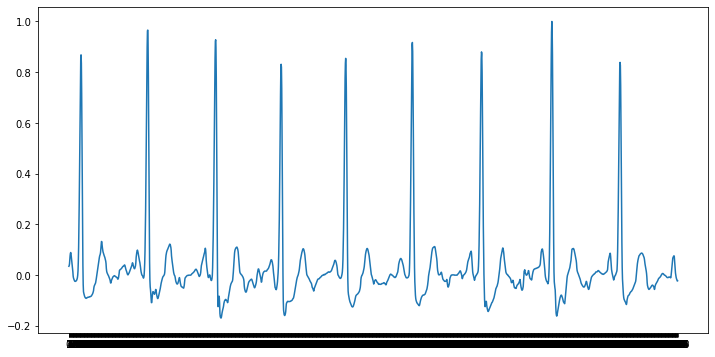

In [3]:
import matplotlib.pyplot as plt
first_row=df.iloc[0]
first_row=first_row[:-2]
length=len(first_row)
first_row_part=first_row[:int(length/10)]
plt.figure(figsize=(12,6))
plt.plot(first_row)
plt.show()

In [4]:
#查看不同数据
df.iloc[:,-1].value_counts()

0    5076
2    2415
1     758
3     279
Name: label, dtype: int64

In [5]:
# from SENetLSTM import *
# import SENetLSTM
# import imp
# imp.reload(SENetLSTM)

import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
np.random.seed(42)
rate=0.7 #0.7的训练集
shuffled_index=np.random.permutation(len(df))
split_index=int(len(df)*rate)
train_index=shuffled_index[:split_index]
test_index=shuffled_index[split_index:]
train_df=df.iloc[train_index].to_numpy()
test_df=df.iloc[test_index].to_numpy()

X_train=train_df[:,:-2]
y_train=train_df[:,-1]
X_test=test_df[:,:-2]
y_test=test_df[:,-1]
print(X_train.shape)
print(y_train.shape)
X_train=X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test=X_test.reshape((X_test.shape[0],X_test.shape[1],1))
# y_train=y_train.reshape((-1,1))
# y_test=y_test.reshape((-1,1))
print(y_train.shape)
print(X_train.shape)
X_train=tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test=tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train=tf.one_hot(y_train,depth=4)
y_test=tf.one_hot(y_test,depth=4)
print(y_test.shape)
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

(5969, 2000)
(5969,)
(5969,)
(5969, 2000, 1)
(2559, 4)


In [139]:
import tensorflow as tf
def SENet_LSTM(ecg_input):
    x=tf.keras.layers.Conv1D(filters=128, kernel_size=20, strides=3, padding='same',activation=tf.nn.relu)(ecg_input)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.MaxPool1D(pool_size=2, strides=3)(x)

    x=tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation=tf.nn.relu)(x)
    # x= SEBlock(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(x)

    x=tf.keras.layers.Conv1D(filters=64, kernel_size=10, strides=1, padding='same', activation=tf.nn.relu)(x)
    # x = SEBlock(x)
    # tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu),
    x=tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(x)
    # tf.keras.layers.Conv1D(filters=512, kernel_size=5, strides=1, padding='same', activation=tf.nn.relu),
    # tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu),
    x=tf.keras.layers.LSTM(20)(x)
    x=tf.keras.layers.Flatten()(x)
    # tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    x=tf.keras.layers.Dropout(rate=0.2)(x)
    x=tf.keras.layers.Dense(units=20, activation=tf.nn.relu)(x)
    x=tf.keras.layers.Dense(units=10, activation=tf.nn.relu)(x)
    output=tf.keras.layers.Dense(units=4,activation=tf.nn.softmax)(x)#activation=tf.nn.softmax
    return output

def SEBlock(inputs, reduction=16, if_train=True):
    x = tf.keras.layers.GlobalAveragePooling1D()(inputs)
    x = tf.keras.layers.Dense(int(x.shape[-1]) // reduction, use_bias=False, activation=tf.keras.activations.relu, trainable=if_train)(x)
    x = tf.keras.layers.Dense(int(inputs.shape[-1]), use_bias=False, activation=tf.keras.activations.hard_sigmoid, trainable=if_train)(x)
    return tf.keras.layers.Multiply()([inputs, x])

In [178]:
from tensorflow.keras import layers,models
def Residual_Neural_Network(ecg_input):
    
    x=residual(ecg_input,64)
    

    for i in range(12):
        #添加卷积层
        x=layers.Conv1D(filters=64,kernel_size=10,strides=3,
                                padding='same',activation='relu')(x)
        #每三层卷积后添加批量归一化和池化层
        if(i+1)%3==0:
           x=layers.BatchNormalization()(x)
           x=layers.MaxPool1D(pool_size=1,strides=1)(x)
        
    
    # 尾部的残差块
    x = residual(x, 64)
    #lstm层
    x=layers.LSTM(10)(x)
    #展平层，准备连接全连接层
    x=layers.Flatten()(x)
    
    #添加全连接层
    x=layers.Dense(20,activation='relu')(x)
    #输出层
    outputs=layers.Dense(4,activation='softmax')(x)
    return outputs

def residual(x,filters,kernel_size=3,stride=1):
    short_cut=x
    #主路径的第一层
    x=layers.Conv1D(filters,kernel_size,padding='same',strides=stride,activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # 主路径的第二层
    x = layers.Conv1D(filters, kernel_size, padding='same', strides=stride, activation=None)(x)
    x = layers.BatchNormalization()(x)
    # 将输入加到主路径的输出
    x = layers.add([short_cut, x])
    x = layers.Activation('relu')(x)
    return x


In [7]:
y_test

<tf.Tensor: shape=(2559, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

In [8]:
print(y_train.shape)
print(X_train.shape)

(5969, 4)
(5969, 2000, 1)


模型训练

Model: "functional_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 2000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_197 (Conv1D)             (None, 2000, 64)     256         input_32[0][0]                   
__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 2000, 64)     256         conv1d_197[0][0]                 
__________________________________________________________________________________________________
conv1d_198 (Conv1D)             (None, 2000, 64)     12352       batch_normalization_103[0][0]    
______________________________________________________________________________________

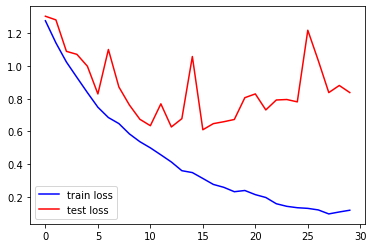

In [180]:
# 定义超参数
num_epochs = 30
batch_size = 40
learning_rate = 0.001


input_ecg=tf.keras.layers.Input(shape=(2000,1))
# output_ecg=SENet_LSTM(input_ecg)
output_ecg=Residual_Neural_Network(input_ecg)
model=tf.keras.Model(input_ecg,output_ecg)
print("model summary:",model.summary())

# 设置优化器
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999,name='Adam')
loss=tf.keras.losses.categorical_crossentropy
metrics=['accuracy']


model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

savedModule=model.fit(X_train,y_train,epochs=num_epochs,batch_size=batch_size,validation_split=0.2)
plt.plot(savedModule.epoch,savedModule.history['loss'],color='blue',label='train loss')
plt.plot(savedModule.epoch,savedModule.history['val_loss'],color="red",label='test loss')
plt.legend()
plt.show()





[[9.2500114e-01 1.2341024e-04 7.4875198e-02 1.8408117e-07]
 [9.1445118e-01 4.2142663e-05 8.5506566e-02 9.9127107e-08]
 [2.7136719e-01 1.7080957e-02 2.4949603e-01 4.6205577e-01]
 ...
 [4.2376477e-01 1.4303934e-03 5.7477051e-01 3.4423778e-05]
 [8.5045296e-01 1.1940081e-04 1.4942537e-01 2.1932681e-06]
 [7.2515917e-01 6.3247629e-04 2.7420533e-01 3.0506033e-06]]
<class 'numpy.ndarray'>
(2719, 4)


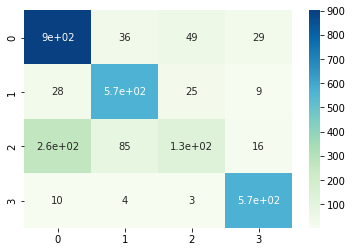

In [147]:
import seaborn as sns
y_predict=model.predict(X_test)
# a=y_predict[20]
y_predict_labels=np.argmax(y_predict,axis=1)
y_test_labels=np.argmax(y_test,axis=1)
y_predict_labels==y_test_labels
#为什么一定要转换成独热码矩阵呢，np.argmax(y_predict,axis=1)后，不就给出标签了吗
# y_predict_matrix=np.zeros(y_predict.shape,dtype=int)
# y_predict_matrix[weizhi]=1
# print(y_predict_matrix)
confusion_matrix =tf.math.confusion_matrix(y_test_labels, y_predict_labels)
sns.heatmap(data=confusion_matrix,annot=True,cmap="GnBu")
# print(confusion_matrix)
print(y_predict)
print(type(y_predict))
print(y_predict.shape)
# print(a)

In [ ]:
print(model.evaluate(X_test,y_test))
predict=model.predict(X_test)       # 输出的不是一个类别，而是样本属于每一个类别的概率
predict=[np.argmax(predict[i]) for i in range(len(predict))]
print('confusion matrix:',tf.math.confusion_matrix(y_test,predict))

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 读取CSV文件
file_path = 'physionet2017.csv'
data = pd.read_csv(file_path)

# 提取ECG信号和标签
X = data.iloc[:, :-2].values  # 最后两列是name和label
y = data['label'].values

# 标签编码
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将数据形状调整为 (样本数, 时间步长, 特征数)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 将标签转换为one-hot编码
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)


# SENet_LSTM模型定义
def SENet_LSTM(ecg_input):
    x = tf.keras.layers.LayerNormalization(axis=-1)(ecg_input)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=20, strides=3, padding='same', activation=tf.nn.relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D(pool_size=2, strides=3)(x)

    x = tf.keras.layers.Conv1D(filters=64, kernel_size=15, strides=1, padding='same', activation=tf.nn.relu)(x)  # filters=32, kernel_size=7
    x = SEBlock(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(x)

    x = tf.keras.layers.Conv1D(filters=64, kernel_size=10, strides=1, padding='same', activation=tf.nn.relu)(x)  # filters=32, kernel_size=10
    x = SEBlock(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(x)

    x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same', activation=tf.nn.relu)(x)  # filters=32, kernel_size=10
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(x)

    # x=tf.keras.layers.LSTM(10)(x)
    x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(32)(x)

    # x=tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)  # rate=0.1

    x = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(x)  # units=20
    x = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)(x)  # units=10
    output = tf.keras.layers.Dense(units=4, activation=tf.nn.softmax)(x)  # units=7
    return output


def SEBlock(inputs, reduction=16, if_train=True):
    x = tf.keras.layers.GlobalAveragePooling1D()(inputs)
    x = tf.keras.layers.Dense(int(x.shape[-1]) // reduction, use_bias=False, activation=tf.keras.activations.relu,
                              trainable=if_train)(x)
    x = tf.keras.layers.Dense(int(inputs.shape[-1]), use_bias=False, activation=tf.keras.activations.hard_sigmoid,
                              trainable=if_train)(x)
    return tf.keras.layers.Multiply()([inputs, x])


# 输入层
ecg_input = tf.keras.Input(shape=(X_train.shape[1], 1))


# 构建模型
output = SENet_LSTM(ecg_input)
model = tf.keras.Model(inputs=ecg_input, outputs=output)

# 编译模型
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# 定义回调函数，记录每个epoch的损失
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}, Loss: {logs['loss']:.4f}")


# 训练模型
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[CustomCallback()]
)

# 评估模型在测试集上的表现
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")



Epoch 1/50
214/214 [==============================] - 13s 63ms/step - loss: 1.3182 - accuracy: 0.5910 - val_loss: 1.2501 - val_accuracy: 0.6120
Epoch 2/50
166/214 [======================>.......] - ETA: 2s - loss: 1.2197 - accuracy: 0.5917

KeyboardInterrupt: 

In [ ]:
X_train.shape

(6822, 2000, 1)

归一化，保留三位
扩充数据集

In [148]:
import scipy
import scipy.signal
import numpy as np
import tensorflow as tf
print(df.iloc[:,-1].value_counts())
min_class_1=df[(df.iloc[:,-1]==1)]
min_class_3=df[(df.iloc[:,-1]==3)]
balance_df=pd.concat([df]+[min_class_1]*2+[min_class_3]*5)
print(balance_df.iloc[:,-1].value_counts())


0    5076
2    2415
1     758
3     279
Name: label, dtype: int64
0    5076
2    2415
1    2274
3    1674
Name: label, dtype: int64


In [149]:
#选择你的数据集 df是原始数据集，balance_df则做过
i_want_this="balance_df"
if(i_want_this=="balance_df"):
    input_df=balance_df.iloc[:,:-2].to_numpy()  #得到输入 dataframe
    output_df=balance_df.iloc[:,-1].to_numpy()  #得到输出  dataframe
elif(i_want_this=="df"):
    input_df=df.iloc[:,:-2].to_numpy()  #得到输入 dataframe
    output_df=df.iloc[:,-1].to_numpy()  #得到输出  dataframe

In [150]:

# print(train_df.type)

# print(train_df[:,:-2].shape)
re_input_df=scipy.signal.resample(input_df,2000,axis=-1)    #重采样
print(re_input_df.shape)
print(output_df.shape)
# x=tf.convert_to_tensor(re_input_df_3)
# y=tf.one_hot(output_df,depth=4)
x=re_input_df.reshape((re_input_df.shape[0],re_input_df.shape[1],1))    #执行此步后x.shape为(8528,2000,1)，一般不这么早转格式
x.shape

(11439, 2000)
(11439,)


(11439, 2000, 1)

In [144]:
def singnal_filter(data,frequency=360,highpass=20,lowpass=1):#frequency为采样频率

    [b,a]=scipy.signal.butter(3,[lowpass/frequency*2, highpass/frequency*2],
                        'bandpass')
    after_filter=[]
    for i in range(len(data)):
        row_data=data[i]
        
        Signal_pro=scipy.signal.filtfilt(b,a,row_data)
        
        Signal_pro=Normalization(Signal_pro)
        Signal_pro=np.round(Signal_pro,3)
        # print(type(Signal_pro))
        print(Signal_pro)
        print(f"this is {i}")
        after_filter.append(Signal_pro)

    return np.array(after_filter)

#归一化函数
def Normalization(data):
    max_num=max(data)
    print(max_num)
    min_num=min(data)
    print(min_num)
    array=np.array((data-min_num)/(max_num-min_num))

    return array

# after_filter=singnal_filter(re_input_df)  #测试用,如果正式使用请注释掉这一行再别处进行滤波操作


In [151]:
import sklearn
import sklearn.model_selection
after_filter=singnal_filter(re_input_df)
X_train,X_test,y_train,y_test=sklearn.model_selection.train_test_split(after_filter,output_df,test_size=0.2,random_state=np.random.seed(42))
X_train=X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test=X_test.reshape((X_test.shape[0],X_test.shape[1],1))
y_train=tf.one_hot(y_train,depth=4)
y_test=tf.one_hot(y_test,depth=4)


0.7570419013976892
-0.22394859504506492
[0.193 0.203 0.213 ... 0.278 0.276 0.274]
this is 0
0.46749884210276
-0.20113559632796088
[0.266 0.264 0.263 ... 0.286 0.287 0.287]
this is 1
0.7623012035097053
-1.4570496376507134
[0.659 0.669 0.679 ... 0.542 0.564 0.586]
this is 2
0.7670119194455994
-0.13878957483529553
[0.231 0.243 0.254 ... 0.558 0.435 0.31 ]
this is 3
0.6369144196575041
-0.6126736292933899
[0.474 0.475 0.477 ... 0.251 0.278 0.304]
this is 4
0.8816362106554753
-1.8865166791593266
[0.471 0.517 0.561 ... 0.785 0.771 0.756]
this is 5
0.8136252695378778
-2.507347600250434
[0.733 0.73  0.727 ... 0.439 0.454 0.461]
this is 6
0.7591647848508993
-0.2579526026658114
[0.208 0.211 0.213 ... 0.498 0.546 0.6  ]
this is 7
0.7946764552833471
-0.39945663786951474
[0.328 0.332 0.336 ... 0.271 0.282 0.294]
this is 8
0.636142158478592
-0.1938694447906647
[0.205 0.206 0.208 ... 0.276 0.277 0.279]
this is 9
0.8950607696793106
-1.1461174543725947
[0.394 0.387 0.381 ... 0.728 0.705 0.681]
this is 1

tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


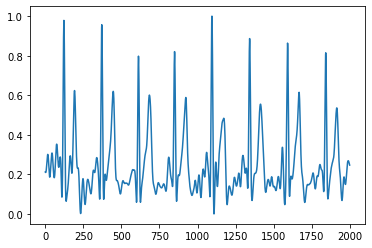

In [112]:
import matplotlib.pyplot as plt
plt.plot(X_train[0])
print(y_train[0])

<class 'numpy.ndarray'>
[[ 0.03503185  0.03715499  0.04458599 ... -0.01910828 -0.02335456
  -0.02229299]]
(1, 2000)
0.899414193765671
-0.22407013682452742
[0.155 0.165 0.174 ... 0.208 0.209 0.21 ]
this is 0
[[0.155 0.165 0.174 ... 0.208 0.209 0.21 ]]
[1.]
[0.]
[[0.155]
 [0.165]
 [0.174]
 ...
 [0.208]
 [0.209]
 [0.21 ]]


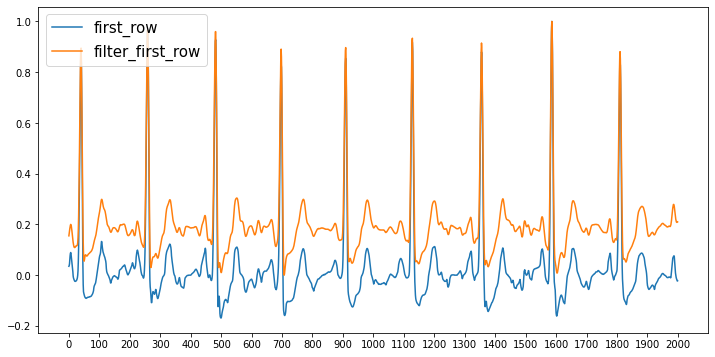

In [113]:
import matplotlib.pyplot as plt
first_row=df.iloc[0]
first_row=first_row[:-2]
length=len(first_row)
first_row_part=first_row[:int(length/10)]
first_row_np=np.array(first_row,dtype=float).reshape(1,2000)
print(type(first_row_np))
print(first_row_np)
print(first_row_np.shape)


filter_first_row=np.array(singnal_filter(first_row_np,200,20,1))

print(filter_first_row)
filter_first_row=filter_first_row.reshape(2000,1)

#归一化
filter_first_row=Normalization(filter_first_row)
filter_first_row=np.round(filter_first_row,3)
print(filter_first_row)
x_axis= np.arange(0, len(first_row))
plt.figure(figsize=(12,6))


plt.plot(x_axis,first_row,label="first_row")
plt.plot(x_axis,filter_first_row,label="filter_first_row")
plt.legend(loc="upper left",fontsize=15)
plt.xticks(np.arange(0,len(first_row)+1,100))
plt.show()


In [292]:
print(type(first_row))
print(type(re_input_df))


print(type(filter_first_row))
print(filter_first_row.shape)
print(first_row.shape)
print(first_row)
print(filter_first_row)

print(f"first row np:{first_row_np}")
print(type(first_row_np))
print(first_row_np.shape)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1, 2000)
(2000,)
0       0.0350318
1        0.037155
2        0.044586
3       0.0636943
4       0.0764331
          ...    
1995   -0.0127389
1996   -0.0159236
1997   -0.0191083
1998   -0.0233546
1999    -0.022293
Name: 0, Length: 2000, dtype: object
[[-0.049654319460094014 -0.038983461165053614 -0.02828495882208235 ...
  0.009439126847346626 0.010409546021236548 0.012057165836964565]]
first row np:[0.03503184713375796 0.037154989384288746 0.044585987261146494 ...
 -0.01910828025477707 -0.02335456475583864 -0.022292993630573247]
<class 'numpy.ndarray'>
(2000,)


In [334]:
copy_df=df
input_data=copy_df.iloc[:,0:2000]
output_data=copy_df.iloc[:,-1]


In [100]:
y_train_np=np.array(y_train)
np.unique(y_train_np,axis=0,return_counts=True)

(array([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]], dtype=float32),
 array([ 230, 1942,  618, 4032], dtype=int64))